 # &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;FACE MASK DETECTION

#### Importing libraries

In [1]:
import tensorflow
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D,Dropout,Flatten,Dense,Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from keras.models import load_model
from imutils.video import VideoStream
import imutils
import time
import cv2

#### Initializing the initial learning rate, number of epochs to train for, and batch size

In [2]:
INIT_LR=1e-4
EPOCHS=20
BS=32

In [3]:
DIRECTORY=r"dataset"
CATEGORIES = ["with_mask","without_mask"]

#### Grabing the list of images in our dataset directory, then initializing the list of data (i.e., images) and class images

In [4]:
data=[]
labels=[]

In [6]:
for category in CATEGORIES:
    path=os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path=os.path.join(path,img)
        image=load_img(img_path,target_size=(224,224))
        image=img_to_array(image)
        image=preprocess_input(image)
        data.append(image)
        labels.append(category)

#### Performing one-hot encoding on the labels

In [7]:
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels=to_categorical(labels)

In [8]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [9]:
trainX,testX,trainY,testY=train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=42)

#### constructing the training image generator for data augmentation

In [10]:
aug=ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,
                       shear_range=0.15,horizontal_flip=True,fill_mode='nearest')

#### Loading the MobileNetV2 network, ensuring the head FC( Fully connected ) layer sets are left off

In [11]:
baseModel=MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

#### Constructing the head of the model that will be placed on top of the base model

In [12]:
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(7,7))(headModel)
headModel=Flatten(name='flatten')(headModel)
headModel=Dense(128,activation='relu')(headModel)
headModel=Dropout(0.5)(headModel)
headModel=Dense(2,activation="softmax")(headModel)

#### Placing the head of the FC model on top of the base model (this will become the actual model we will train)

In [13]:
model=Model(inputs=baseModel.input,outputs=headModel)

#### Looping over all layers in the base model and freeze them so they will not be updated during the first training process

In [14]:
for layer in baseModel.layers:
    layer.trainable=False

#### Compiling our model

In [15]:
print("[INFO] compiling model...")
opt=Adam(lr=INIT_LR,decay=INIT_LR/EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])

[INFO] compiling model...


#### Training the head of the network

In [16]:
print("[INFO] training head...")
H=model.fit(aug.flow(trainX,trainY,batch_size=BS),
           steps_per_epoch=len(trainX)//BS,
           validation_data=(testX,testY),
           validation_steps=len(testX)//BS,
           epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
191/191 [==============================] - 137s 702ms/step - loss: 0.4868 - accuracy: 0.7838 - val_loss: 0.0940 - val_accuracy: 0.9850
Epoch 2/20
191/191 [==============================] - 134s 700ms/step - loss: 0.0976 - accuracy: 0.9765 - val_loss: 0.0547 - val_accuracy: 0.9883
Epoch 3/20
191/191 [==============================] - 136s 714ms/step - loss: 0.0635 - accuracy: 0.9835 - val_loss: 0.0437 - val_accuracy: 0.9883
Epoch 4/20
191/191 [==============================] - 138s 721ms/step - loss: 0.0511 - accuracy: 0.9860 - val_loss: 0.0416 - val_accuracy: 0.9902
Epoch 5/20
191/191 [==============================] - 141s 740ms/step - loss: 0.0483 - accuracy: 0.9867 - val_loss: 0.0372 - val_accuracy: 0.9902
Epoch 6/20
191/191 [==============================] - 142s 742ms/step - loss: 0.0422 - accuracy: 0.9855 - val_loss: 0.0309 - val_accuracy: 0.9915
Epoch 7/20
191/191 [==============================] - 147s 768ms/step - loss: 0.0369 - accuracy: 0.9

#### Making predictions on the testing set

In [17]:
print("[INFO] evaluating network...")
predIdxs=model.predict(testX,batch_size=BS)

[INFO] evaluating network...


#### For each image in the testing set we are finding the index of the label with corresponding largest predicted probability

In [18]:
predIdxs=np.argmax(predIdxs,axis=1)

#### Showing a nicely formatted classification report

In [19]:
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       766
without_mask       1.00      0.99      1.00       768

    accuracy                           1.00      1534
   macro avg       1.00      1.00      1.00      1534
weighted avg       1.00      1.00      1.00      1534



#### Saving the face mask detector model

In [20]:
print("[INFO] saving mask dector model...")
model.save("face_mask_detector.model",save_format="h5")

[INFO] saving mask dector model...


#### Plotting the training loss and accuracy

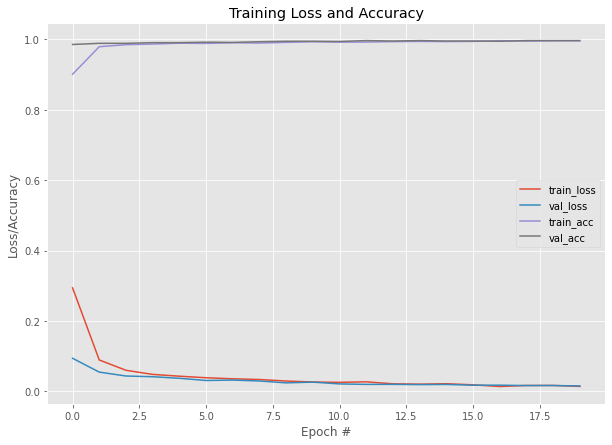

In [21]:
N=EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(10,7))
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history["accuracy"],label="train_acc")
plt.plot(np.arange(0,N),H.history["val_accuracy"],label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")
plt.savefig("plot.png")

#### Using our Face Mask Detector model in real time camera

In [22]:
def detect_and_predict_mask(frame,faceNet,maskNet):
    (h,w)=frame.shape[:2]
    blob=cv2.dnn.blobFromImage(frame,1.0,(224,224),(104.0,177.0,123.0))
    faceNet.setInput(blob)
    detections=faceNet.forward()
    print(detections.shape)
    faces=[]
    locs=[]
    preds=[]
    for i in range(0,detections.shape[2]):
        confidence=detections[0,0,i,2]
        if(confidence>0.5):
            box=detections[0,0,i,3:7]*np.array([w,h,w,h])
            (startX,startY,endX,endY)=box.astype("int")
            (startX,startY)=(max(0,startX),max(0,startY))
            (endX,endY)=(min(w-1,endX),min(h-1,endY))
            face=frame[startY:endY,startX:endX]
            face=cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            face=cv2.resize(face,(224,224))
            face=img_to_array(face)
            face=preprocess_input(face)
            faces.append(face)
            locs.append((startX,startY,endX,endY))
    if(len(faces)>0):
        faces=np.array(faces,dtype="float32")
        preds=maskNet.predict(faces,batch_size=32)
    return(locs,preds)

In [23]:
prototxtPath=r"deploy.prototxt"
weightsPath=r"res10_300x300_ssd_iter_140000.caffemodel"
faceNet=cv2.dnn.readNet(prototxtPath,weightsPath)

In [24]:
maskNet=load_model("face_mask_detector.model")

In [25]:
print("[INFO] starting video stream...")
vs=VideoStream(src=0).start()
while(True):
    frame=vs.read()
    frame=imutils.resize(frame,width=400)
    (locs,preds)=detect_and_predict_mask(frame,faceNet,maskNet)
    for (box,pred) in zip(locs,preds):
        (startX,startY,endX,endY)=box
        (mask,withoutMask)=pred
        label="Mask" if mask>withoutMask else "No Mask"
        color=(0,255,0) if label=="Mask" else (0,0,255)
        label="{}:{:2f}%".format(label,max(mask,withoutMask)*100)
        cv2.putText(frame,label,(startX,startY-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(frame,(startX,startY),(endX,endY),color,2)
    cv2.imshow("Frame",frame)
    key=cv2.waitKey(1) & 0xFF
    if(key==ord("q")):
        break
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 200, 7)
(1, 1, 2